# Part 4. Modeling and Evaluation II

## Import basic libraries and load data

This section import the basic python libraries for usage as well as loading the dataset from the previous notebook.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
data_df = pd.read_csv('./datasets/merge_data_with_amenities_final_baseyear2014.csv')

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210180 entries, 0 to 210179
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     210180 non-null  object 
 1   town                     210180 non-null  object 
 2   flat_type                210180 non-null  object 
 3   block                    210180 non-null  object 
 4   street_name              210180 non-null  object 
 5   storey_range             210180 non-null  object 
 6   floor_area_sqm           210180 non-null  float64
 7   flat_model               210180 non-null  object 
 8   lease_commence_date      210180 non-null  int64  
 9   resale_price             210180 non-null  float64
 10  year                     210180 non-null  int64  
 11  month                    210180 non-null  int64  
 12  longitude                210180 non-null  float64
 13  latitude                 210180 non-null  float64
 14  near

## Modeling and Evaluation
This section implements 3 classification models namely Decision Tree, Random Forest and K-nearest Neighbors (KNN) to predict the flat type given other characteristics/features without using the resale price. At the end of this section, one of the models will be chosen for the prediction of the flat type.

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
cont_vars = ['floor_area_sqm']
nom_vars = ['flat_model']

X = data_df[cont_vars+nom_vars]
y = data_df['flat_type']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, cont_vars),
        ("cat", categorical_transformer, nom_vars),
    ], remainder='passthrough'
)

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
def compute(cm_matrix, class_list):
    var_list = []
    for value in range(len(cm_matrix)):
        tp = 0
        fn = 0
        fp = 0
        for row_index in range(cm.shape[0]): # row
            col = value
#             cm[row_index][col]
            if row_index == (col):
                tp = cm[row_index][col]
            else:
                fp += cm[row_index][col]
        for col_index in range(cm.shape[1]): # col
            row = value
        #     cm[row_index][col]
            if col_index != (row):
                fn += cm[row][col_index]

        var_list.append([class_list[value], tp, fp, fn]) 
    return var_list

def compute_metrics(df):
    if 'acc' not in df.columns:
        df['acc'] = ''
    if 'recall' not in df.columns:
        df['recall'] = ''
    if 'prec' not in df.columns:
        df['prec'] = ''
    if 'f1' not in df.columns:
        df['f1'] = ''
    for index, row in df.iterrows():
        df['acc'] = df['tp']/(df['tp']+df['fn']+df['fp'])
        df['recall'] = df['tp']/(df['tp']+df['fn'])
        df['prec'] = df['tp']/(df['tp']+df['fp'])  
        df['f1'] = 2*df['recall']*df['prec']/(df['recall']+df['prec'])


In [7]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth = 7, random_state=42))]
)

start = time.time()
dtree_model.fit(X_train, y_train)


# dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
end = time.time()
dtree_fit_time = end - start
print('Time taken is %.2f' % dtree_fit_time)

Time taken is 0.31


In [8]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

dtree_predictions = dtree_model.predict(X_test)
# creating a confusion matrix
# actual is row, predict is columns
# tn, fp, fn, tp
cm = confusion_matrix(y_test, dtree_predictions)
# plot_confusion_matrix(dtree_model, X_test, dtree_predictions, cmap='Blues')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dtree_model.classes_, 
                              )
# disp.plot(cmap='Blues')

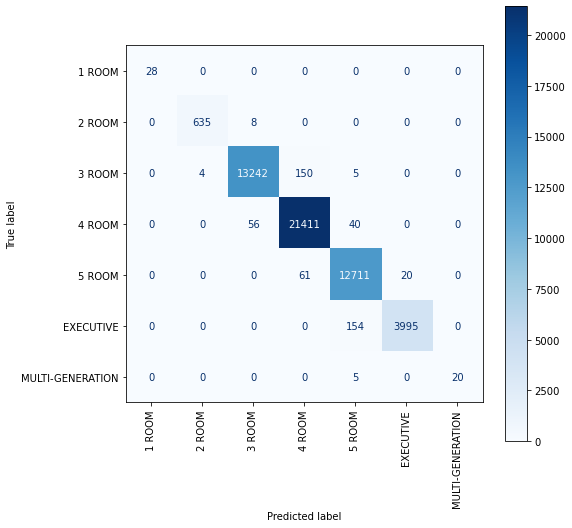

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

In [10]:
data = compute(cm, dtree_model.classes_)
data

[['1 ROOM', 28, 0, 0],
 ['2 ROOM', 635, 4, 8],
 ['3 ROOM', 13242, 64, 159],
 ['4 ROOM', 21411, 211, 96],
 ['5 ROOM', 12711, 204, 81],
 ['EXECUTIVE', 3995, 20, 154],
 ['MULTI-GENERATION', 20, 0, 5]]

In [11]:
cols = ['flat_type', 'tp', 'fp', 'fn']
metrics_df = pd.DataFrame(data, columns=cols)
metrics_df

,flat_type,tp,fp,fn
0,1 ROOM,28,0,0
1,2 ROOM,635,4,8
2,3 ROOM,13242,64,159
3,4 ROOM,21411,211,96
4,5 ROOM,12711,204,81
5,EXECUTIVE,3995,20,154
6,MULTI-GENERATION,20,0,5


In [12]:
compute_metrics(metrics_df)
metrics_df.set_index('flat_type')

,tp,fp,fn,acc,recall,prec,f1
flat_type,,,,,,,
1 ROOM,28,0,0,1.000000,1.000000,1.000000,1.000000
2 ROOM,635,4,8,0.981453,0.987558,0.993740,0.990640
3 ROOM,13242,64,159,0.983439,0.988135,0.995190,0.991650
4 ROOM,21411,211,96,0.985864,0.995536,0.990241,0.992882
5 ROOM,12711,204,81,0.978070,0.993668,0.984204,0.988914
EXECUTIVE,3995,20,154,0.958263,0.962883,0.995019,0.978687
MULTI-GENERATION,20,0,5,0.800000,0.800000,1.000000,0.888889


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dtree_predictions, target_names=dtree_model.classes_))

                  precision    recall  f1-score   support

          1 ROOM       1.00      1.00      1.00        28
          2 ROOM       0.99      0.99      0.99       643
          3 ROOM       1.00      0.99      0.99     13401
          4 ROOM       0.99      1.00      0.99     21507
          5 ROOM       0.98      0.99      0.99     12792
       EXECUTIVE       1.00      0.96      0.98      4149
MULTI-GENERATION       1.00      0.80      0.89        25

        accuracy                           0.99     52545
       macro avg       0.99      0.96      0.98     52545
    weighted avg       0.99      0.99      0.99     52545



In [14]:
from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500, min_samples_split=3)
#                                                                                     .fit(X_train, y_train)
rf_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42, 
                                                                                 n_jobs=-1, n_estimators=500, 
                                                                                 min_samples_split=3))]
)

start = time.time()
rf_model.fit(X_train, y_train)
end = time.time()
rf_fit_time = end - start
print('Time taken is %.2f' % rf_fit_time)

Time taken is 11.64


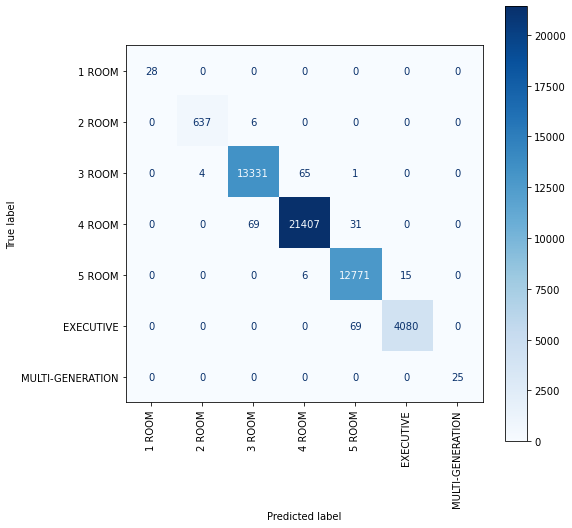

In [15]:
rf_predictions = rf_model.predict(X_test)

# creating a confusion matrix
# actual is row, predict is columns
# tn, fp, fn, tp
cm = confusion_matrix(y_test, rf_predictions)
# from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
# plot_confusion_matrix(dtree_model, X_test, dtree_predictions, cmap='Blues')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_, 
                              )

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

In [16]:
data = compute(cm, rf_model.classes_)
data

[['1 ROOM', 28, 0, 0],
 ['2 ROOM', 637, 4, 6],
 ['3 ROOM', 13331, 75, 70],
 ['4 ROOM', 21407, 71, 100],
 ['5 ROOM', 12771, 101, 21],
 ['EXECUTIVE', 4080, 15, 69],
 ['MULTI-GENERATION', 25, 0, 0]]

In [17]:
metrics_df = pd.DataFrame(data, columns=cols)
compute_metrics(metrics_df)
metrics_df.set_index('flat_type')

,tp,fp,fn,acc,recall,prec,f1
flat_type,,,,,,,
1 ROOM,28,0,0,1.000000,1.000000,1.000000,1.000000
2 ROOM,637,4,6,0.984544,0.990669,0.993760,0.992212
3 ROOM,13331,75,70,0.989240,0.994777,0.994405,0.994591
4 ROOM,21407,71,100,0.992075,0.995350,0.996694,0.996022
5 ROOM,12771,101,21,0.990538,0.998358,0.992154,0.995246
EXECUTIVE,4080,15,69,0.979827,0.983369,0.996337,0.989811
MULTI-GENERATION,25,0,0,1.000000,1.000000,1.000000,1.000000


In [18]:
print(classification_report(y_test, rf_predictions, target_names=rf_model.classes_))

                  precision    recall  f1-score   support

          1 ROOM       1.00      1.00      1.00        28
          2 ROOM       0.99      0.99      0.99       643
          3 ROOM       0.99      0.99      0.99     13401
          4 ROOM       1.00      1.00      1.00     21507
          5 ROOM       0.99      1.00      1.00     12792
       EXECUTIVE       1.00      0.98      0.99      4149
MULTI-GENERATION       1.00      1.00      1.00        25

        accuracy                           0.99     52545
       macro avg       1.00      0.99      1.00     52545
    weighted avg       0.99      0.99      0.99     52545



In [19]:
from sklearn.neighbors import KNeighborsClassifier
# knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

knn_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=5))]
)

start = time.time()
knn_model.fit(X_train, y_train)
end = time.time()
knn_fit_time = end - start
print('Time taken is %.2f' % knn_fit_time)

Time taken is 0.25


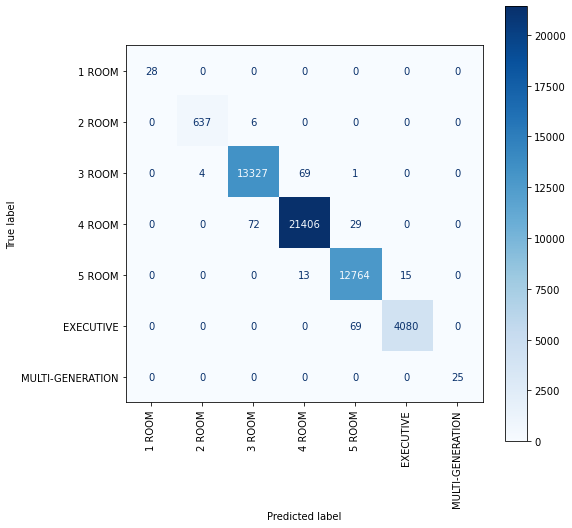

In [20]:
knn_predictions = knn_model.predict(X_test)

# creating a confusion matrix
# actual is row, predict is columns
# tn, fp, fn, tp
cm = confusion_matrix(y_test, knn_predictions)
# from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
# plot_confusion_matrix(dtree_model, X_test, dtree_predictions, cmap='Blues')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_model.classes_, 
                              )

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
# disp.xticks(rotation=90)

In [21]:
data = compute(cm, knn_model.classes_)
data

[['1 ROOM', 28, 0, 0],
 ['2 ROOM', 637, 4, 6],
 ['3 ROOM', 13327, 78, 74],
 ['4 ROOM', 21406, 82, 101],
 ['5 ROOM', 12764, 99, 28],
 ['EXECUTIVE', 4080, 15, 69],
 ['MULTI-GENERATION', 25, 0, 0]]

In [22]:
metrics_df = pd.DataFrame(data, columns=cols)
compute_metrics(metrics_df)
metrics_df.set_index('flat_type')

,tp,fp,fn,acc,recall,prec,f1
flat_type,,,,,,,
1 ROOM,28,0,0,1.000000,1.000000,1.000000,1.000000
2 ROOM,637,4,6,0.984544,0.990669,0.993760,0.992212
3 ROOM,13327,78,74,0.988723,0.994478,0.994181,0.994330
4 ROOM,21406,82,101,0.991523,0.995304,0.996184,0.995744
5 ROOM,12764,99,28,0.990148,0.997811,0.992304,0.995050
EXECUTIVE,4080,15,69,0.979827,0.983369,0.996337,0.989811
MULTI-GENERATION,25,0,0,1.000000,1.000000,1.000000,1.000000


In [23]:
print(classification_report(y_test, knn_predictions, target_names=knn_model.classes_))

                  precision    recall  f1-score   support

          1 ROOM       1.00      1.00      1.00        28
          2 ROOM       0.99      0.99      0.99       643
          3 ROOM       0.99      0.99      0.99     13401
          4 ROOM       1.00      1.00      1.00     21507
          5 ROOM       0.99      1.00      1.00     12792
       EXECUTIVE       1.00      0.98      0.99      4149
MULTI-GENERATION       1.00      1.00      1.00        25

        accuracy                           0.99     52545
       macro avg       1.00      0.99      1.00     52545
    weighted avg       0.99      0.99      0.99     52545



In [24]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210180 entries, 0 to 210179
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     210180 non-null  object 
 1   town                     210180 non-null  object 
 2   flat_type                210180 non-null  object 
 3   block                    210180 non-null  object 
 4   street_name              210180 non-null  object 
 5   storey_range             210180 non-null  object 
 6   floor_area_sqm           210180 non-null  float64
 7   flat_model               210180 non-null  object 
 8   lease_commence_date      210180 non-null  int64  
 9   resale_price             210180 non-null  float64
 10  year                     210180 non-null  int64  
 11  month                    210180 non-null  int64  
 12  longitude                210180 non-null  float64
 13  latitude                 210180 non-null  float64
 14  near

In [25]:
data_df['flat_type'] = data_df['flat_type'].map({'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, \
                                                 '4 ROOM': 4, '5 ROOM': 5, 'EXECUTIVE': 6, \
                                                 'MULTI-GENERATION': 7})

In [26]:
my_order = list(data_df['flat_type'].value_counts().index.sort_values())

In [27]:
data_df['flat_type'].value_counts().index

Int64Index([4, 3, 5, 6, 2, 1, 7], dtype='int64')

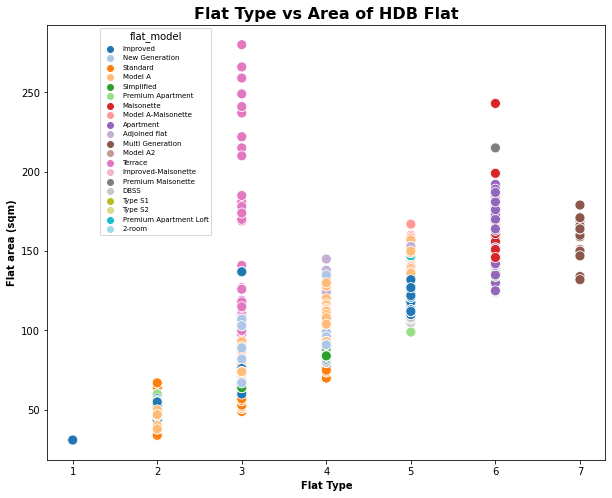

In [28]:
plt.figure(figsize=(10, 8))
sp = sns.scatterplot(data=data_df, x="flat_type", y="floor_area_sqm", hue='flat_model', palette="tab20", s=100)
sp.set_title('Flat Type vs Area of HDB Flat', fontsize='16', fontweight='bold')
sp.set_xlabel('Flat Type', fontweight='bold')
sp.set_ylabel('Flat area (sqm)', fontweight='bold')
sp.legend(ncol=1, bbox_to_anchor=(0.3, 1), fontsize='7', title='flat_model');

### Conclusion

Answer to Question 2C:
The KNN classification model was chosen for predicting the flat type of HDB flat using features like the size of the flat as well as the flat model. This model can achieve a considerably high f1 score among the different flat type (classes) and it also takes less than 1 sec to fit the training dataset. The classes of flat type were converted to numerical numbers so that we can do a scatterplot with flat model as the catogorical feature and we can see that the size of the flat along with the flat type can help to predict the flat type.